## Python implementation of advanced iterative algorithm (AIA) for phase extraction

##### Wang, Z., & Han, B. (2004). Advanced iterative algorithm for phase extraction of randomly phase-shifted interferograms. Optics Letters, 29(14), 1671. https://doi.org/10.1364/OL.29.001671

In [2]:
import pylab as plt
import numpy as np
from skimage import data, exposure
from skimage import io
from tqdm.notebook import trange
plt.gray();plt.tight_layout();plt.close()

/opt/conda/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


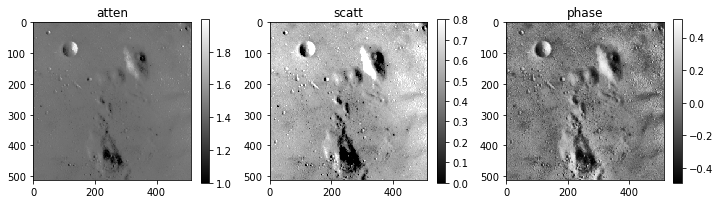

In [3]:
atten = data.moon()/256
low, high = np.percentile(atten, (2, 98))
scatt = exposure.rescale_intensity(atten, in_range=(low, high)) * 0.8
phase = exposure.equalize_adapthist(atten, clip_limit=0.03)

atten += 1
phase -= phase.mean()

fig, ax = plt.subplots(1, 3, figsize=(4*3, 3))
for a,im,tag in zip(ax.flat,(atten,scatt,phase),("atten","scatt","phase")):
    a.set_title(tag)
    c = a.imshow(im)
    plt.colorbar(c, ax=a)

### Background

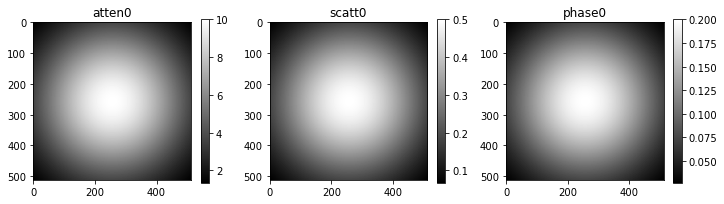

In [4]:
ny,nx = atten.shape
py, px = np.mgrid[-ny//2:ny//2, -nx//2:nx//2]
atten0 = 10. * np.exp(-(px**2 + py**2)/256**2)
scatt0 = 0.5 * np.exp(-(px**2 + py**2)/256**2)
phase0 = 0.2 * np.exp(-(px**2 + py**2)/256**2)

fig, ax = plt.subplots(1, 3, figsize=(4*3, 3))
for a,im,tag in zip(ax.flat,(atten0,scatt0,phase0),("atten0","scatt0","phase0")):
    a.set_title(tag)
    c = a.imshow(im)
    plt.colorbar(c, ax=a)

Array shape of fg and bg:  (5, 512, 512) (5, 512, 512)


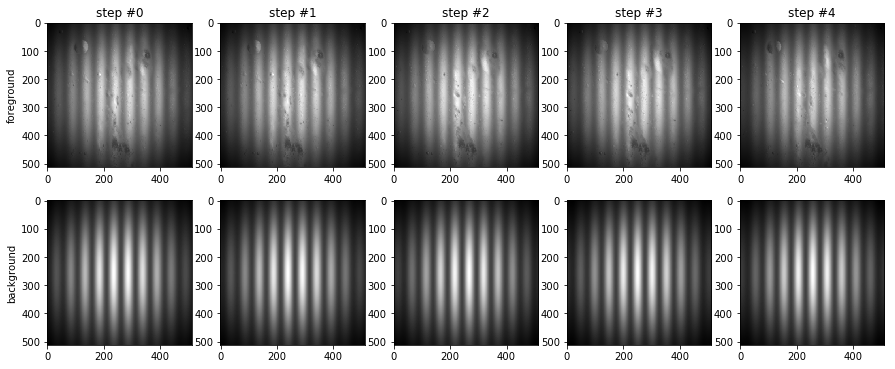

In [5]:
def make_interferograms(atten, scatt, phase, kx, steps, step_err=0):
    ny, nx = atten.shape
    py, px = np.mgrid[:ny, :nx]
    cf = 2 * np.pi * kx * px / nx  # carrier fringe
    ps = 2 * np.pi * np.arange(1, steps+1) / steps  # phase step
    if step_err>0:
        ps = np.random.normal(ps, step_err)  # stepping error
    return atten * (1  + scatt * np.cos(phase + cf + ps.reshape(-1, 1, 1)))

# interferograms
steps, kx, step_err = 5, 10, 1
fg = make_interferograms(atten*atten0, scatt*scatt0, phase+phase0, kx, steps, step_err)
bg = make_interferograms(atten0, scatt0, phase0, kx, steps, step_err)
print("Array shape of fg and bg: ", fg.shape, bg.shape)

fig, ax = plt.subplots(2, steps, figsize=(3*steps, 6))
ax[0,0].set_ylabel("foreground")
ax[1,0].set_ylabel("background")
for i in range(steps):
    ax[0, i].set_title(f"step #{i}")
    ax[0, i].imshow(fg[i])
    ax[1, i].imshow(bg[i])

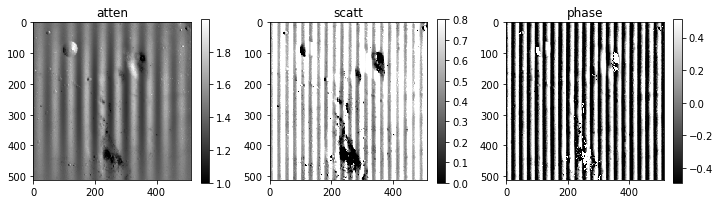

In [6]:
def component01(imgs):
    steps, ny, nx = imgs.shape
    pstep = (2*np.pi*np.arange(1, steps+1)/steps).reshape(steps, 1, 1)
    c0 = np.mean(imgs, axis=0)
    c1 = np.mean(2*imgs * (np.cos(pstep) + 1j*np.sin(pstep)), axis=0)
    return c0, c1

fg0, fg1 = component01(fg)
bg0, bg1 = component01(bg)
a = fg0/bg0
s = np.abs(fg1/bg1)/a
p = -np.angle(fg1/bg1)
p -= p.mean()

fig, ax = plt.subplots(1, 3, figsize=(4*3, 3))
imgs,tags = (a,s,p), ("atten","scatt","phase")
vmins = (atten.min(), scatt.min(), phase.min())
vmaxs = (atten.max(), scatt.max(), phase.max())
for a,im,tag,vmin,vmax in zip(ax.flat,imgs,tags,vmins,vmaxs):
    a.set_title(tag)
    c = a.imshow(im, vmin=vmin, vmax=vmax)
    plt.colorbar(c, ax=a)

### AIA method

In [7]:
def aia(imgs, eps=1e-4, n_iter_min=20, n_iter_max=30):
    steps, ny, nx = imgs.shape
    imgs = imgs.reshape(steps, -1)

    # initial value
    pstep = (2*np.pi*np.arange(1, steps+1)/steps).reshape(steps, 1)
    
    def solve(N, cosp, sinp, stage):
        A = np.asarray([[N, np.sum(cosp), np.sum(sinp)],
                        [np.sum(cosp), np.sum(cosp**2), np.sum(cosp*sinp)],
                        [np.sum(sinp), np.sum(sinp*cosp), np.sum(sinp**2)]])
        B = np.asarray([np.sum(imgs, axis=stage),
                        np.sum(imgs*cosp, axis=stage),
                        np.sum(imgs*sinp, axis=stage)])
        return np.linalg.solve(A, B)

    with trange(n_iter_max) as progress:
        for i in progress:
            # stage 0
            a, b, c = solve(steps, np.cos(pstep), np.sin(pstep), stage=0)
            atten, phase, scatt = a, np.arctan2(-c, b), np.sqrt(b**2+c**2)/a

            # stage 1
            a, b, c = solve(ny*nx, np.cos(phase), np.sin(phase), stage=1)
            prev, pstep = pstep, np.arctan2(-c, b).reshape(steps, 1)

            # stop condition
            e = np.sum((prev-pstep)**2)
            if e<eps and i>n_iter_min:
                break
            progress.set_postfix(e=f"{e:.4e}")

    atten = atten.reshape(ny,nx)
    scatt = scatt.reshape(ny,nx)
    phase = phase.reshape(ny,nx)
    return atten,scatt,phase

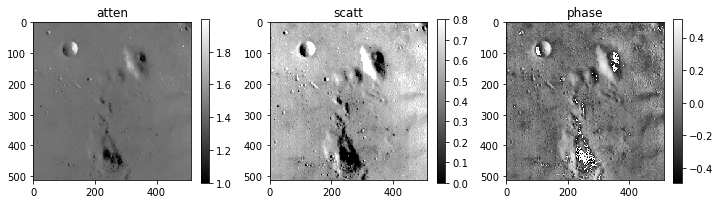

In [8]:
fga,fgs,fgp = aia(fg)
bga,bgs,bgp = aia(bg)
a = fga/bga
s = fgs/bgs
p = np.angle(np.exp(1j*fgp)/np.exp(1j*bgp))
p -= p.mean()

fig, ax = plt.subplots(1, 3, figsize=(4*3, 3))
imgs,tags = (a,s,p), ("atten","scatt","phase")
vmins = (atten.min(), scatt.min(), phase.min())
vmaxs = (atten.max(), scatt.max(), phase.max())
for a,im,tag,vmin,vmax in zip(ax.flat,imgs,tags,vmins,vmaxs):
    a.set_title(tag)
    c = a.imshow(im, vmin=vmin, vmax=vmax)
    plt.colorbar(c, ax=a)